<a href="https://colab.research.google.com/github/ds4geo/ds4geo/blob/master/DS4GEO_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Topics:
1. Indexing lists
2. Dicts and indexing dicts
3. Functions, methods, attributes
4. argmax vs boolean array indexing examples
5. 

In [3]:
file_name_list = ["STD-1.csv","Sample-1.csv"]
data_list = []
for fn in file_name_list:
  data_list.append(pd.read_csv(r"https://raw.githubusercontent.com/oscarbranson/latools/master/tests/test_dir/test_data/"+fn, header=3))
data_list[1]["Time [Sec]"] = data_list[1]["Time [Sec]"] + data_list[0]["Time [Sec]"].max()
data = pd.concat(data_list)

In [4]:
data

,Time [Sec],Mg24,Mg25,Al27,Ca43,Ca44,Mn55,Sr88,Ba137,Ba138
0,0.367,200.00,300.00,2200.14,366.67,17809.04,8652.16,0.00,0.0,12.5
1,0.725,466.67,200.00,2800.22,200.00,14506.00,7551.64,0.00,0.0,12.5
2,1.082,366.67,175.00,2000.11,466.67,13255.01,7151.47,100.00,25.0,0.0
3,1.439,466.67,75.00,1600.07,300.00,14405.92,8652.16,33.33,0.0,0.0
4,1.796,466.67,225.00,3000.25,200.00,14506.00,7551.64,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,497.717,166.67,150.00,2400.16,433.34,14105.67,6801.33,66.67,0.0,0.0
695,498.074,466.67,275.00,3200.29,300.00,14606.08,8702.18,33.33,0.0,25.0
696,498.431,200.00,350.00,3100.27,400.00,14455.96,9102.38,133.33,0.0,0.0
697,498.788,333.34,500.01,2500.18,100.00,13505.20,8452.06,33.33,50.0,25.0


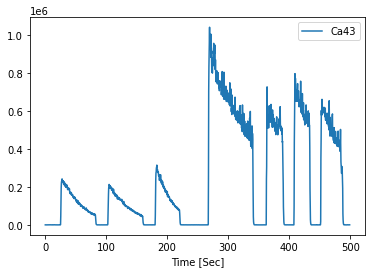

In [5]:
data.plot("Time [Sec]", "Ca43")

In [8]:
# convert to numpy and split into time and trace elment data
dat = data.to_numpy()
time = dat[:,0]
raw_te = dat[:,1:]

(1398, 9)

**1. Identify background and apply background correction**
1. Identify Signal (Sample and Standard), and Background parts of signal
Do manually - can be done with GUI or algorithms, but do it manually now to teach basics.

A) Create list of start and end values for the first and last background sections

(0.0, 300000.0)

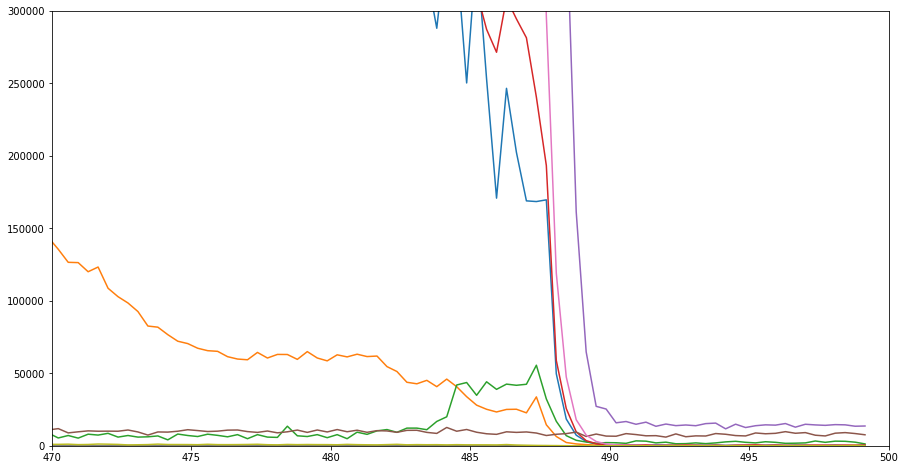

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(time, raw_te)
plt.plot()
plt.xlim(470,500)
plt.ylim(0,0.3e6)

In [ ]:
background_locations = [{"start": 0, "end": 25},
                        {"start": 491, "end": 498}]


In [ ]:
# Slice background locations

In [ ]:
# Calculate stats

(0.0, 1000.0)

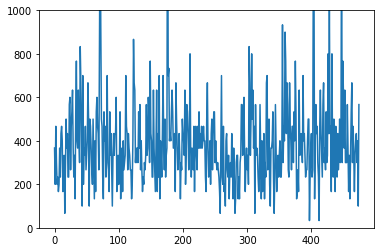

In [ ]:
plt.plot(np.array(data["Ca43"])[data["Ca43"]<2000])
plt.ylim(0,1000)

In [ ]:
# Apply correction
bg_correction = 

SyntaxError: ignored

In [ ]:
dnp = data.to_numpy()


In [ ]:
dnp[:,0]

array([3.67000e-01, 7.25000e-01, 1.08200e+00, ..., 4.98431e+02,
       4.98788e+02, 4.99142e+02])

In [ ]:
data

,Time [Sec],Mg24,Mg25,Al27,Ca43,Ca44,Mn55,Sr88,Ba137,Ba138
0,0.367,200.00,300.00,2200.14,366.67,17809.04,8652.16,0.00,0.0,12.5
1,0.725,466.67,200.00,2800.22,200.00,14506.00,7551.64,0.00,0.0,12.5
2,1.082,366.67,175.00,2000.11,466.67,13255.01,7151.47,100.00,25.0,0.0
3,1.439,466.67,75.00,1600.07,300.00,14405.92,8652.16,33.33,0.0,0.0
4,1.796,466.67,225.00,3000.25,200.00,14506.00,7551.64,100.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
694,497.717,166.67,150.00,2400.16,433.34,14105.67,6801.33,66.67,0.0,0.0
695,498.074,466.67,275.00,3200.29,300.00,14606.08,8702.18,33.33,0.0,25.0
696,498.431,200.00,350.00,3100.27,400.00,14455.96,9102.38,133.33,0.0,0.0
697,498.788,333.34,500.01,2500.18,100.00,13505.20,8452.06,33.33,50.0,25.0


In [ ]:
# Functions vs Methods/Attributes
np.shape(dnp)

(1398, 10)

**2. Standardize to Ca**

**3. Calibrate to standards**